<a href="https://colab.research.google.com/github/bislara/Age-Progression-Using-PyTorch/blob/master/Age_progression_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!mkdir .kaggle

In [0]:
import json

token = {"username":"biswajeetsahoo54","key":"1ce5cac341a71f094959287c3a210236"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!cp /content/.kaggle/kaggle.json  /root/.kaggle/kaggle.json

In [5]:
!kaggle datasets list

ref                                                            title                                                size  lastUpdated          downloadCount  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
paultimothymooney/covid19-containment-and-mitigation-measures  COVID-19 containment and mitigation measures         91KB  2020-03-30 14:01:44            727  
allen-institute-for-ai/CORD-19-research-challenge              COVID-19 Open Research Dataset Challenge (CORD-19)  729MB  2020-03-27 23:46:53          36711  
skylord/coronawhy                                              CoronaWhy                                             2GB  2020-03-30 18:07:00            118  
unanimad/dataisbeautiful                                       Reddit - Data is Beautiful                           11MB  2020-03-21 22:28:28           1340  
rubenssjr/brasilian-houses-to-rent            

In [6]:
!kaggle datasets download -d jangedoo/utkface-new

 97% 322M/331M [00:09<00:00, 29.5MB/s]
100% 331M/331M [00:09<00:00, 37.6MB/s]


In [0]:
!unzip \*.zip

In [0]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torch.nn.functional as F
import torchvision.utils as vutils
import pickle
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [0]:
n_channel = 3
n_disc = 16
n_gen = 64   #first o/p of Generator
n_encode = 64 # first o/p of conv layer of encoder
n_l = 10
n_z = 50
img_size = 128
batchSize = 24
use_cuda = torch.cuda.is_available()
n_age = int(n_z/n_l)
n_gender = int(n_z/2)

In [12]:
print(n_age," ",n_gender," ")

5   25  


In [0]:
des_dir = "/content/dataset/"

dataset = dset.ImageFolder(root=des_dir,
                           transform=transforms.Compose([
                               transforms.Resize(img_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size= batchSize,
                                         shuffle=True)

In [0]:
des_dir = "/content/utkface_aligned_cropped/"

dataset1 = dset.ImageFolder(root=des_dir,
                           transform=transforms.Compose([
                               transforms.Resize(img_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader1 = torch.utils.data.DataLoader(dataset1,
                                         batch_size= batchSize,
                                         shuffle=True)

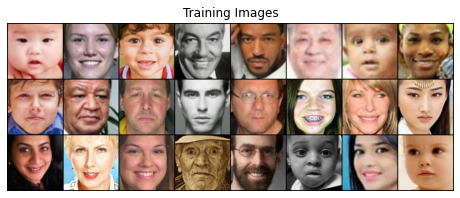

In [15]:
import matplotlib.pyplot as plt

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].cuda()[:64], padding=2, normalize=True).cpu(),(1,2,0)))


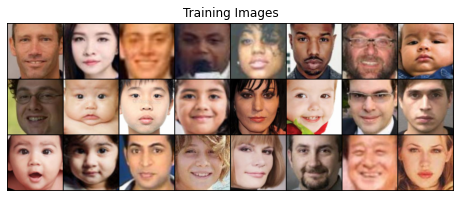

In [16]:
import matplotlib.pyplot as plt

# Plot some training images
real_batch1 = next(iter(dataloader1))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch1[0].cuda()[:64], padding=2, normalize=True).cpu(),(1,2,0)))


In [0]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.conv = nn.Sequential(
            #input: 3*128*128
            nn.Conv2d(n_channel,n_encode,5,2,2),
            nn.ReLU(),

            nn.Conv2d(n_encode,2*n_encode,5,2,2),
            nn.ReLU(),

            nn.Conv2d(2*n_encode,4*n_encode,5,2,2),
            nn.ReLU(),

            nn.Conv2d(4*n_encode,8*n_encode,5,2,2),
            nn.ReLU(),

        )
        self.fc = nn.Linear(8*n_encode*8*8,50)

    def forward(self,x):
        conv = self.conv(x).view(-1,8*n_encode*8*8)
        out = self.fc(conv)
        return out

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.fc = nn.Sequential(nn.Linear(n_z+n_l*n_age+n_gender,
                                          8*8*n_gen*16),
                                nn.ReLU())
        self.upconv= nn.Sequential(
            nn.ConvTranspose2d(16*n_gen,8*n_gen,4,2,1),
            nn.ReLU(),

            nn.ConvTranspose2d(8*n_gen,4*n_gen,4,2,1),
            nn.ReLU(),

            nn.ConvTranspose2d(4*n_gen,2*n_gen,4,2,1),
            nn.ReLU(),

            nn.ConvTranspose2d(2*n_gen,n_gen,4,2,1),
            nn.ReLU(),

            nn.ConvTranspose2d(n_gen,n_channel,3,1,1),
            nn.Tanh(),

        )

    def forward(self,z,age,gender):
        ## duplicate age & gender conditions as descripted in https://github.com/ZZUTK/Face-Aging-CAAE
        l = age.repeat(1,n_age).float()
        k = gender.view(-1,1).repeat(1,n_gender).float()

        x = torch.cat([z,l,k],dim=1)
        fc = self.fc(x).view(-1,16*n_gen,8,8)
        out = self.upconv(fc)
        return out


In [0]:
class Dimg(nn.Module):
    def __init__(self):
        super(Dimg,self).__init__()
        self.conv_img = nn.Sequential(
            nn.Conv2d(n_channel,n_disc,4,2,1),
        )
        self.conv_l = nn.Sequential(
            nn.ConvTranspose2d(n_l*n_age+n_gender, n_l*n_age+n_gender, 64, 1, 0),
            nn.ReLU()
        )
        self.total_conv = nn.Sequential(
            nn.Conv2d(n_disc+n_l*n_age+n_gender,n_disc*2,4,2,1),
            nn.ReLU(),

            nn.Conv2d(n_disc*2,n_disc*4,4,2,1),
            nn.ReLU(),

            nn.Conv2d(n_disc*4,n_disc*8,4,2,1),
            nn.ReLU()
        )

        self.fc_common = nn.Sequential(
            nn.Linear(8*8*img_size,1024),
            nn.ReLU()
        )
        self.fc_head1 = nn.Sequential(
            nn.Linear(1024,1),
            nn.Sigmoid()
        )
        self.fc_head2 = nn.Sequential(
            nn.Linear(1024,n_l),
            nn.Softmax()
        )

    def forward(self,img,age,gender):
        ## duplicate age & gender conditions as descripted in https://github.com/ZZUTK/Face-Aging-CAAE
        l = age.repeat(1,n_age,1,1,)
        k = gender.repeat(1,n_gender,1,1,)
        conv_img = self.conv_img(img)
        conv_l   = self.conv_l(torch.cat([l,k],dim=1))
        catted   = torch.cat((conv_img,conv_l),dim=1)
        total_conv = self.total_conv(catted).view(-1,8*8*img_size)
        body = self.fc_common(total_conv)

        head1 = self.fc_head1(body)
        head2 = self.fc_head2(body)

        return head1,head2


In [0]:
class Dz(nn.Module):
    def __init__(self):
        super(Dz,self).__init__()
        self.model = nn.Sequential(
            nn.Linear(n_z,n_disc*4),
            nn.ReLU(),

            nn.Linear(n_disc*4,n_disc*2),
            nn.ReLU(),

            nn.Linear(n_disc*2,n_disc),
            nn.ReLU(),

            nn.Linear(n_disc,1),
            nn.Sigmoid()
        )
    def forward(self,z):
        return self.model(z)

In [0]:
if use_cuda:
    netE = Encoder().cuda()
    netD_img = Dimg().cuda()
    netD_z  = Dz().cuda()
    netG = Generator().cuda()
else:
    netE = Encoder()
    netD_img = Dimg()
    netD_z  = Dz()
    netG = Generator()

In [0]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find("Linear") !=-1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [23]:
netE.apply(weights_init)
netD_img.apply(weights_init)
netD_z.apply(weights_init)
netG.apply(weights_init)

Generator(
  (fc): Sequential(
    (0): Linear(in_features=125, out_features=65536, bias=True)
    (1): ReLU()
  )
  (upconv): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): Tanh()
  )
)

In [24]:
print(netE)
print(netG)
print(netD_img)
print(netD_z)

Encoder(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (5): ReLU()
    (6): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (7): ReLU()
  )
  (fc): Linear(in_features=32768, out_features=50, bias=True)
)
Generator(
  (fc): Sequential(
    (0): Linear(in_features=125, out_features=65536, bias=True)
    (1): ReLU()
  )
  (upconv): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  

In [0]:
optimizerE = optim.Adam(netE.parameters(),lr=0.0002,betas=(0.5,0.999))
optimizerD_z = optim.Adam(netD_z.parameters(),lr=0.0002,betas=(0.5,0.999))
optimizerD_img = optim.Adam(netD_img.parameters(),lr=0.0002,betas=(0.5,0.999))
optimizerG = optim.Adam(netG.parameters(),lr=0.0002,betas=(0.5,0.999))

In [0]:
def one_hot(labelTensor,batchSize,n_l,use_cuda=False):
    oneHot = - torch.ones(batchSize*n_l).view(batchSize,n_l)
    for i,j in enumerate(labelTensor):
        oneHot[i,j] = 1
    if use_cuda:
        return Variable(oneHot).cuda()
    else:
        return Variable(oneHot)

In [0]:
if use_cuda:
    BCE = nn.BCELoss().cuda()
    L1  = nn.L1Loss().cuda()
    CE = nn.CrossEntropyLoss().cuda()
    MSE = nn.MSELoss().cuda()
else:
    BCE = nn.BCELoss()
    L1  = nn.L1Loss()
    CE = nn.CrossEntropyLoss()
    MSE = nn.MSELoss()

In [0]:
def TV_LOSS(imgTensor,img_size=128):
    x = (imgTensor[:,:,1:,:]-imgTensor[:,:,:img_size-1,:])**2
    y = (imgTensor[:,:,:,1:]-imgTensor[:,:,:,:img_size-1])**2

    out = (x.mean(dim=2)+y.mean(dim=3)).mean()
    return out

In [0]:
niter=10

In [0]:
fixed_l = -torch.ones(80*10).view(80,10)

In [0]:
for i,l in enumerate(fixed_l):
    l[i//8] = 1

In [0]:
fixed_g = -1*torch.FloatTensor([1,-1,-1,-1,-1,1,1,1]).view(-1,1).repeat(10,1)

In [0]:
fixed_l_v = Variable(fixed_l)
fixed_g_v = Variable(fixed_g)
if use_cuda:
    fixed_l_v = fixed_l_v.cuda()
    fixed_g_v = fixed_g_v.cuda()

In [0]:
outf='/content/result_tv_gender/'

In [39]:
for epoch in range(niter):
    for i,(img_data,img_label) in enumerate(dataloader):

        # make image variable and class variable

        img_data_v = Variable(img_data)
        img_age = img_label/2
        img_gender = img_label%2*2-1

        img_age_v = Variable(img_age).view(-1,1)
        img_gender_v = Variable(img_gender.float())

        if epoch == 0 and i == 0:
            fixed_noise = img_data[:8].repeat(10,1,1,1)
            fixed_g = img_gender[:8].view(-1,1).repeat(10,1)


            fixed_img_v = Variable(fixed_noise)
            fixed_g_v = Variable(fixed_g)

            pickle.dump(fixed_noise,open("fixed_noise.p","wb"))

            if use_cuda:
                fixed_img_v = fixed_img_v.cuda()
                fixed_g_v = fixed_g_v.cuda()
        if use_cuda:
            img_data_v = img_data_v.cuda()
            img_age_v = img_age_v.cuda()
            img_gender_v = img_gender_v.cuda()

        # make one hot encoding version of label
        batchSize = img_data_v.size(0)
        age_ohe = one_hot(img_age,batchSize,n_l,use_cuda)

        # prior distribution z_star, real_label, fake_label
        z_star = Variable(torch.FloatTensor(batchSize*n_z).uniform_(-1,1)).view(batchSize,n_z)
        real_label = Variable(torch.ones(batchSize).fill_(1)).view(-1,1)
        fake_label = Variable(torch.ones(batchSize).fill_(0)).view(-1,1)

        if use_cuda:
            z_star, real_label, fake_label = z_star.cuda(),real_label.cuda(),fake_label.cuda()


        ## train Encoder and Generator with reconstruction loss
        netE.zero_grad()
        netG.zero_grad()

        # EG_loss 1. L1 reconstruction loss
        z = netE(img_data_v)
        reconst = netG(z,age_ohe,img_gender_v)
        EG_L1_loss = L1(reconst,img_data_v)


        # EG_loss 2. GAN loss - image
        z = netE(img_data_v)
        reconst = netG(z,age_ohe,img_gender_v)
        D_reconst,_ = netD_img(reconst,age_ohe.view(batchSize,n_l,1,1),img_gender_v.view(batchSize,1,1,1))
        G_img_loss = BCE(D_reconst,real_label)



        ## EG_loss 3. GAN loss - z
        Dz_prior = netD_z(z_star)
        Dz = netD_z(z)
        Ez_loss = BCE(Dz,real_label)

        ## EG_loss 4. TV loss - G
        reconst = netG(z.detach(),age_ohe,img_gender_v)
        G_tv_loss = TV_LOSS(reconst)

        EG_loss = EG_L1_loss + 0.0001*G_img_loss + 0.01*Ez_loss + G_tv_loss
        EG_loss.backward()

        optimizerE.step()
        optimizerG.step()



        ## train netD_z with prior distribution U(-1,1)
        netD_z.zero_grad()
        Dz_prior = netD_z(z_star)
        Dz = netD_z(z.detach())

        Dz_loss = BCE(Dz_prior,real_label)+BCE(Dz,fake_label)
        Dz_loss.backward()
        optimizerD_z.step()



        ## train D_img with real images
        netD_img.zero_grad()
        D_img,D_clf = netD_img(img_data_v,age_ohe.view(batchSize,n_l,1,1),img_gender_v.view(batchSize,1,1,1))
        D_reconst,_ = netD_img(reconst.detach(),age_ohe.view(batchSize,n_l,1,1),img_gender_v.view(batchSize,1,1,1))

        D_loss = BCE(D_img,real_label)+BCE(D_reconst,fake_label)
        D_loss.backward()
        optimizerD_img.step()

        print("{",epoch,"/",niter,"}","----[",i,"/",len(dataloader),"]")



    ## save fixed img for every 20 step
    fixed_z = netE(fixed_img_v)
    fixed_fake = netG(fixed_z,fixed_l_v,fixed_g_v)
    vutils.save_image(fixed_fake.data,
                '%s/reconst_epoch%03d.png' % (outf,epoch+1),
                normalize=True)

    ## checkpoint
    if epoch%2==0:
        torch.save(netE.state_dict(),"%s/netE_%03d.pth"%(outf,epoch+1))
        torch.save(netG.state_dict(),"%s/netG_%03d.pth"%(outf,epoch+1))
        torch.save(netD_img.state_dict(),"%s/netD_img_%03d.pth"%(outf,epoch+1))
        torch.save(netD_z.state_dict(),"%s/netD_z_%03d.pth"%(outf,epoch+1))


    msg1 = "epoch:{}, step:{}".format(epoch+1,i+1)
    msg2 = format("EG_L1_loss:%f"%(EG_L1_loss.item()),"<30")+"|"+format("G_img_loss:%f"%(G_img_loss.item()),"<30")
    msg5 = format("G_tv_loss:%f"%(G_tv_loss.item()),"<30")+"|"+"Ez_loss:%f"%(Ez_loss.item())
    msg3 = format("D_img:%f"%(D_img.mean().item()),"<30")+"|"+format("D_reconst:%f"%(D_reconst.mean().item()),"<30")\
    +"|"+format("D_loss:%f"%(D_loss.item()),"<30")
    msg4 = format("D_z:%f"%(Dz.mean().item()),"<30")+"|"+format("D_z_prior:%f"%(Dz_prior.mean().item()),"<30")\
    +"|"+format("Dz_loss:%f"%(Dz_loss.item()),"<30")

    print()
    print(msg1)
    print(msg2)
    print(msg5)
    print(msg3)
    print(msg4)
    print()
    print("-"*80)



/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Streaming output truncated to the last 5000 lines.
{ 6 / 10 } ----[ 617 / 1396 ]
{ 6 / 10 } ----[ 618 / 1396 ]
{ 6 / 10 } ----[ 619 / 1396 ]
{ 6 / 10 } ----[ 620 / 1396 ]
{ 6 / 10 } ----[ 621 / 1396 ]
{ 6 / 10 } ----[ 622 / 1396 ]
{ 6 / 10 } ----[ 623 / 1396 ]
{ 6 / 10 } ----[ 624 / 1396 ]
{ 6 / 10 } ----[ 625 / 1396 ]
{ 6 / 10 } ----[ 626 / 1396 ]
{ 6 / 10 } ----[ 627 / 1396 ]
{ 6 / 10 } ----[ 628 / 1396 ]
{ 6 / 10 } ----[ 629 / 1396 ]
{ 6 / 10 } ----[ 630 / 1396 ]
{ 6 / 10 } ----[ 631 / 1396 ]
{ 6 / 10 } ----[ 632 / 1396 ]
{ 6 / 10 } ----[ 633 / 1396 ]
{ 6 / 10 } ----[ 634 / 1396 ]
{ 6 / 10 } ----[ 635 / 1396 ]
{ 6 / 10 } ----[ 636 / 1396 ]
{ 6 / 10 } ----[ 637 / 1396 ]
{ 6 / 10 } ----[ 638 / 1396 ]
{ 6 / 10 } ----[ 639 / 1396 ]
{ 6 / 10 } ----[ 640 / 1396 ]
{ 6 / 10 } ----[ 641 / 1396 ]
{ 6 / 10 } ----[ 642 / 1396 ]
{ 6 / 10 } ----[ 643 / 1396 ]
{ 6 / 10 } ----[ 644 / 1396 ]
{ 6 / 10 } ----[ 645 / 1396 ]
{ 6 / 10 } ----[ 646 / 1396 ]
{ 6 / 10 } ----[ 647 / 1396 ]
{ 6 / 10 } ----[ 64

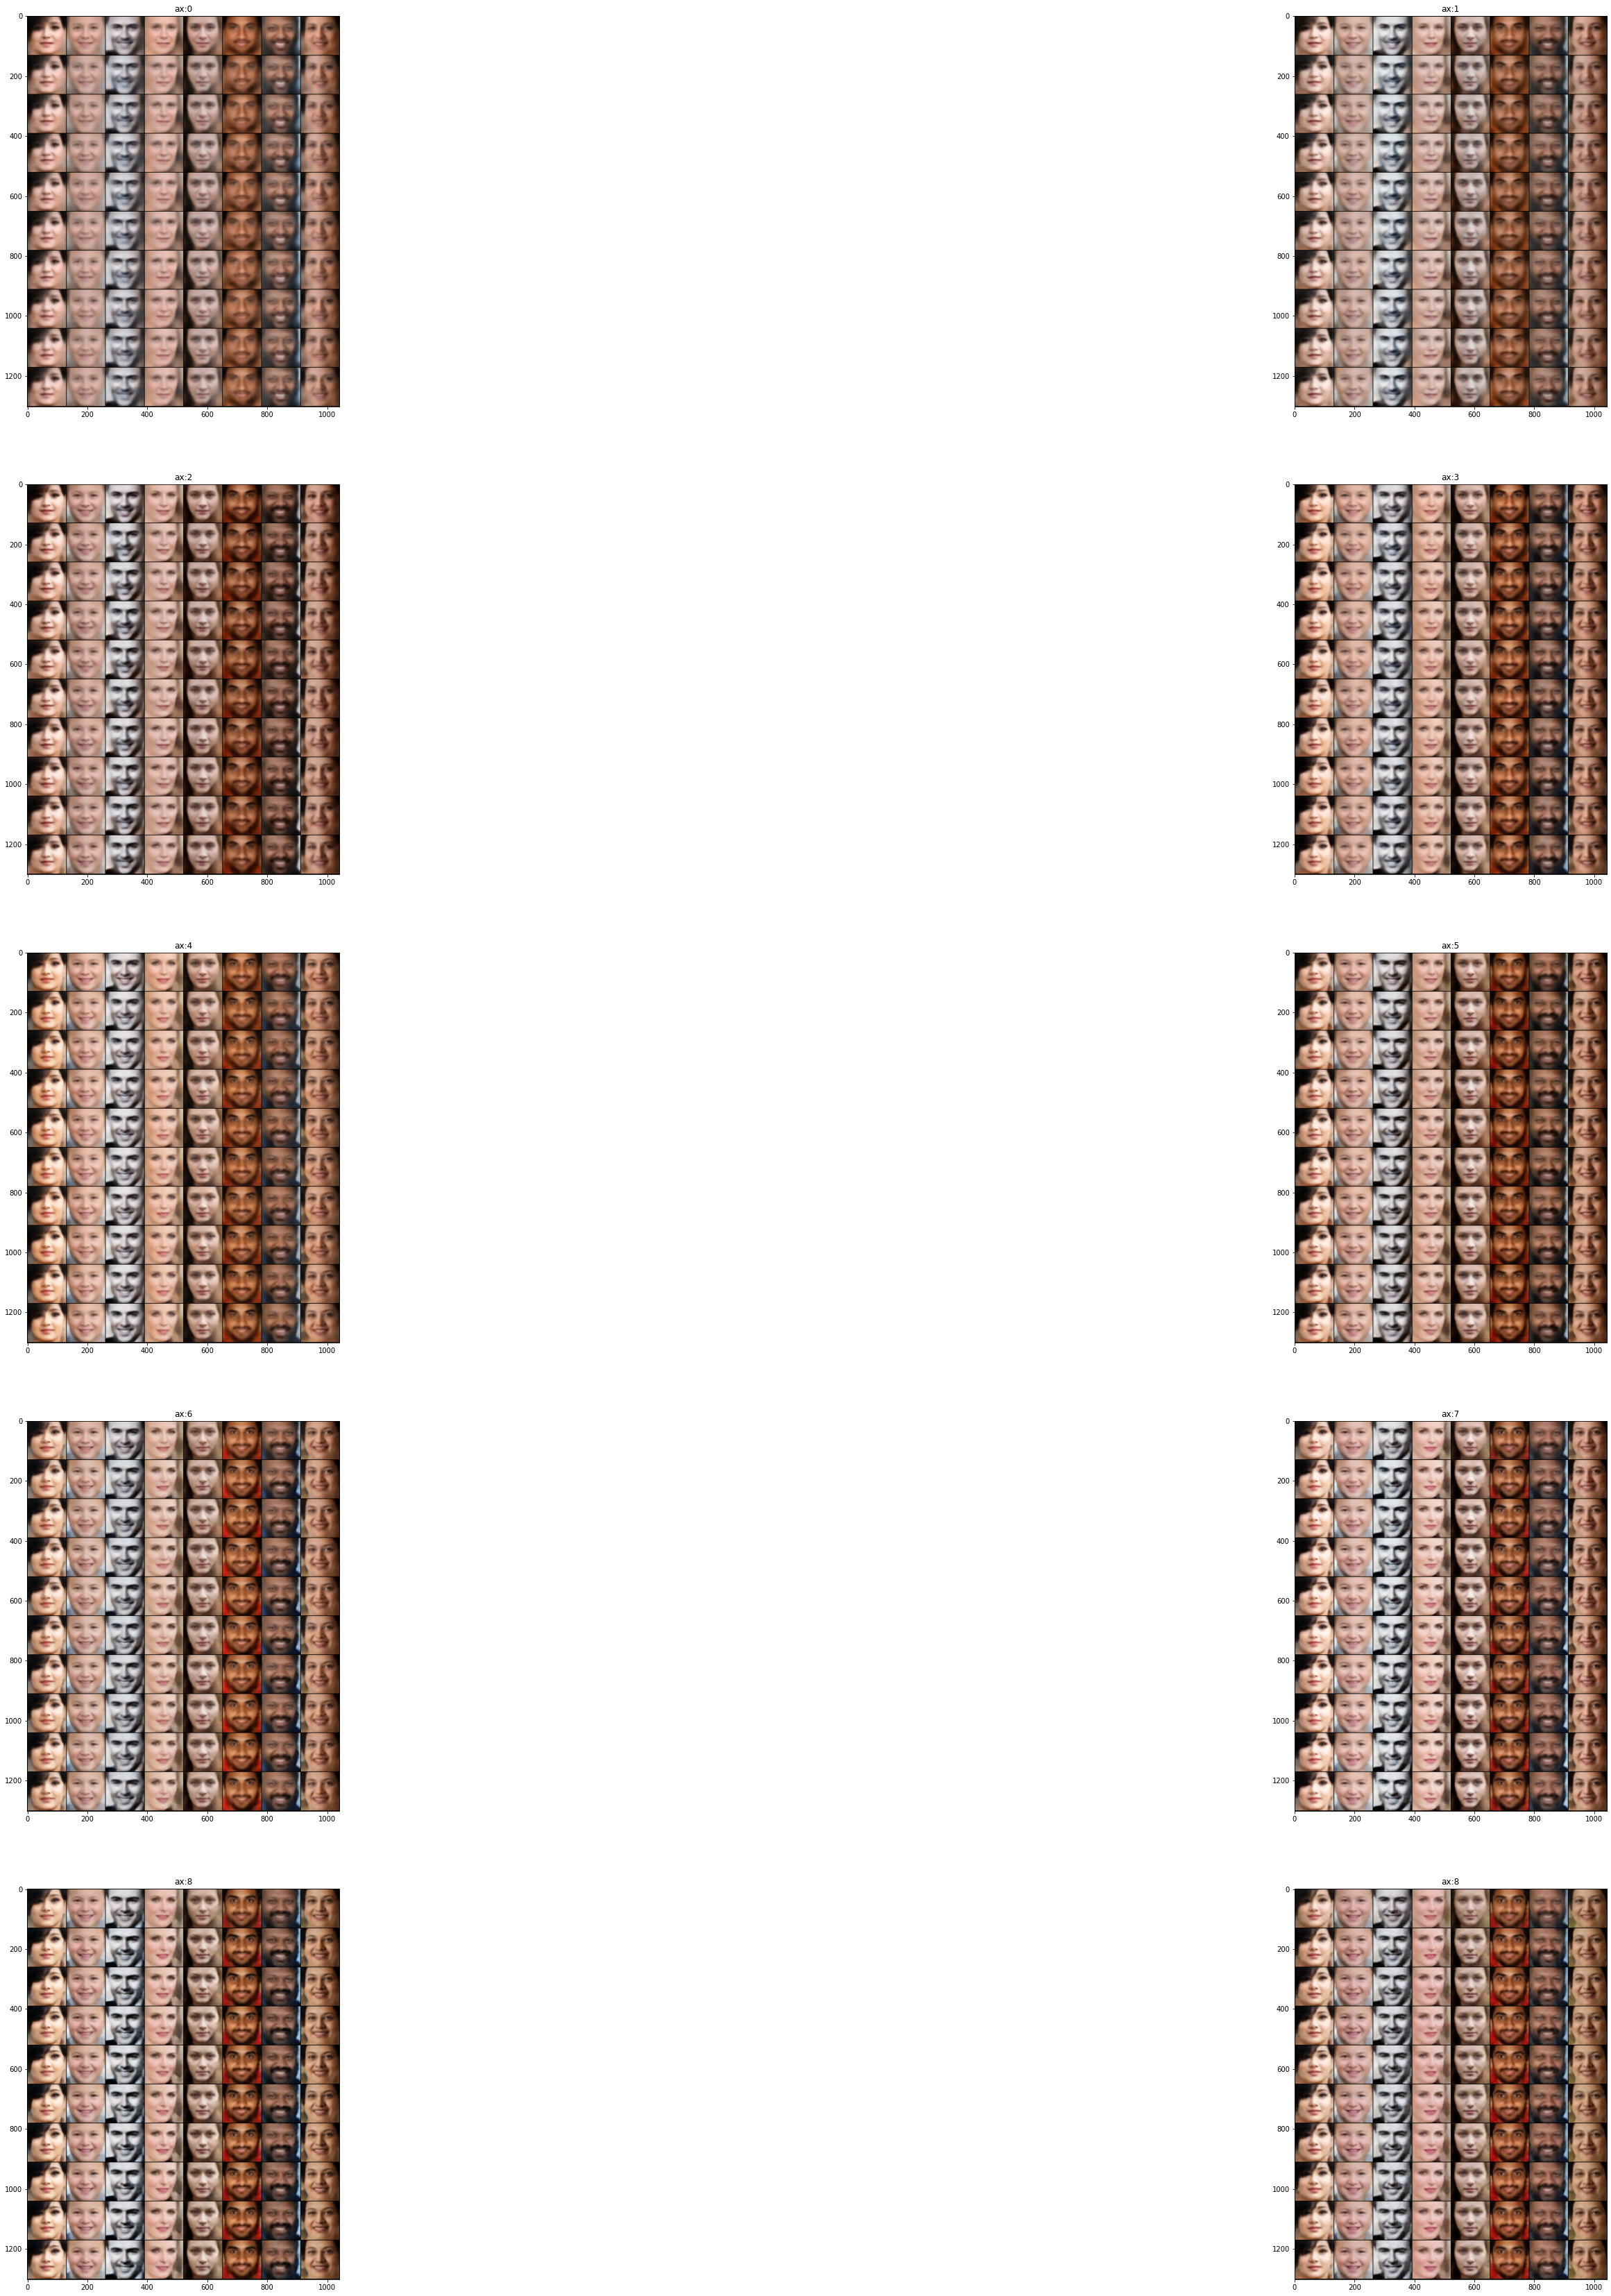

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

fig = plt.figure(figsize=(60, 60))
columns = 2
rows = 5

# ax enables access to manipulate each of subplots
ax = []
import matplotlib.image as img2
  
for i in range(9):

    img = img2.imread('/content/result_tv_gender/reconst_epoch00'+str(i+1)+'.png')
    # print(img)

    # create subplot and append to ax
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title("ax:"+str(i))  # set title
    plt.imshow(img)

img = img2.imread('/content/result_tv_gender/reconst_epoch0'+str(i+2)+'.png')
    # print(img)

    # create subplot and append to ax
ax.append( fig.add_subplot(rows, columns, i+2) )
ax[-1].set_title("ax:"+str(i))  # set title
plt.imshow(img)

plt.show()  # finally, render the plot
